# Introductory tutorial

This notebook provides a full pipeline of using FairBench to perform fairness analysis on the output of a machine learning model running on tabular data. It shows how to create fairness reports and explore them for problematic values, while also serving as an introduction to the domain of responsible fairness assessment. Thus it does *not* cover advanced features like complex data modalities (vision, text, graphs), non-binary predictive attributes, continuous sensitive attributes, and leveraging the differentiable nature of assessment for machine learnin.

As a preparatory step, install the library with `pip install fairbench[interactive]`, where the `[interactive]` part is needed to create nice plots with libraries like matplotlib instead of showing ascii versions in the console. After installing the library, import it and let's start!

In [1]:
import fairbench as fb

## Prepare data
You can grab ready-to-use data and training outcomes from the `fb.bench` module. For demonstration purposes, here we opt for manually calling `fb.read_csv`, which loads CSV files from the web or from within archives stored in the web, and imports them as datasets with the [pandas](https://pandas.pydata.org/) library under the hood. You can load your own datasets too! For now, let us look what Adult data look like. FairBench lets us know that it downloaded a couple of files in the process. These are cached for future use an a local *data/* folder.

In [2]:
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
train = fb.read_csv(train_url, header=None, skipinitialspace=True)
test = fb.read_csv(test_url,header=None,skipinitialspace=True,skiprows=[0])
train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Use `fb.features` to convert training and test data into [numpy](https://numpy.org/) arrays. This method takes as inputs the identifiers of numeric and categorical columns, and is a shorthand for common pandas dataframe manipulation that would take too much space to write all at once. We want to use the selected column data to estimate whether a person's income is greater than 50K, which is depicted in the last column. This will be the target label of our predictions. Train and test data heve same format, with the only difference beeing the extra fullstop at the end of test data labels.

In [3]:
numeric = [0, 4, 11, 12]
categorical = [3, 5, 6]

x_train = fb.features(train, numeric, categorical)
y_train = (train[14]==">50K").values

x = fb.features(test, numeric, categorical)
y = (test[14]==">50K.").values

## Make AI predictions
In this demonstration will use [scikit-learn](https://scikit-learn.org/) to train an machine learning model and obtain some predictions over test data, which is the practical setting we tackle. Our goal is to create a performant system, but we still need to assess fairness risks. We choose scikit-learn for this example because is a dependency of FairBench and therefore already installed. However, the library also accepts [pytorch](https://pytorch.org/), [tensorflow](https://www.tensorflow.org/), or [jax](https://jax.readthedocs.io/en/latest/index.html) tensors, as well as native Python lists and iterable objects of other libraries. 

In our specific setting, we further scale datasets to reduce the curse of dimensionality and therefore improve predictions (this is unrelated to fairness but a good practice to keep in mind). We train a logistic regression model model and finally obtain predictions `yhat` for the test data. Let's quickly print the accuracy of those predictions. Not bad, it seems!

In [4]:
import sklearn
from sklearn.linear_model import LogisticRegression

x_train_scaled = sklearn.preprocessing.MinMaxScaler().fit_transform(x_train)
x = sklearn.preprocessing.MinMaxScaler().fit_transform(x)

classifier = LogisticRegression(max_iter=1000)
classifier = classifier.fit(x_train_scaled, y_train)
yhat = classifier.predict(x)
float(fb.accuracy(y, yhat))

0.8352066826362017

## Sensitive attributes
But how is our model fairing in terms of fairness?
To answer this we first need to select sensitive attributes, which indicate which demographic properties need to be checked for non-discrimination. There may be many of those attributes, so FairBench provides a data structure called `Fork` to pack any number of them. You can then treat a fork of sensitive attributes as one variable with multiple values - similar to a dictionary enriched with operations that let it act like one data instance.

Forks define computational branches of population groups, where branch is a sensitive attribute column with binary values indicating membership to each group, such as Male, Female, or non-Binary. Then, base measures will be computed independently on each branch to be compared. This is all a little too technical, so as practice let us create a fork holding one attribute (for now); the Gender. This holds only binary values for the Adult dataset, which means that we cannot really investigate what happens for non-binary genders. But it's the only data available, since this is an old dataset. In new systems, do make sure to be inclusive.

There are several ways to create forks, for example by manually naming their branches with keyword arguments in the fork's constructor and passing respective tensors or arrays. However, we can also create branches automatically be automatically creating binary encodings of the values found in iterables (e.g., arrays, lists, pandas columns). This is what we will use to create our first fork.

In [5]:
sensitive = fb.Fork(fb.categories@test[9])  ## or sensitive = fb.Fork(Male=np.array(...), Female=np.array(...))
print(sensitive.Male)
sensitive

NumPyTensor(array([1, 1, 1, ..., 1, 1, 1]))


Female,[0 0 0 ... 0 0 0]
Male,[1 1 1 ... 1 1 1]


Most numerical operations are overloaded for forks. In fact, under the hood, FairBench leverages [eagerpy](https://eagerpy.jonasrauber.de/) to make all computations look the same regardless of backend. Forks inherit eagerpy's operations to apply them on all data branches. The outcome is again a fork with the same branches and the operation outcome store there. Here we will sum the sensitive attribute columns to obtain the presence of population groups in the data. Forks of numeric values can be printed and visualized, as seen below. We also implement ipython integration to show them as pretty html within notebooks.

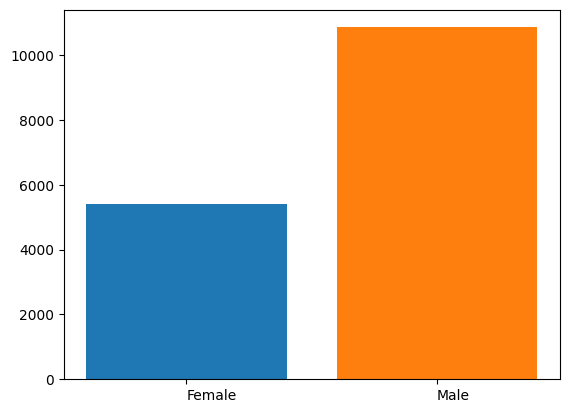

Female,5421
Male,10860


In [6]:
presence = sensitive.sum()
fb.visualize(presence)
presence

## Reports
We previously used `fb.accuracy` to assess predictive performance over the whole test data vs predictions. FairBench offers several performance measures cattering to several prediction tasks. Importantly, those measures can accept sensitive attribute forks to compute a different assessment per branch that focuses only on the specific population groups. In our running example, this means that we may compute accuracy values for all genders. Here is an example, where we can see that there is some small but non-negligible discrepancy between how well our model predicts income for the two analysed genders.

In [7]:
acc = fb.accuracy(predictions=yhat, labels=y, sensitive=sensitive)
acc

Female,0.916
Male,0.795


Our system yields more or less similar predictions for each sensitive group of people. But, before discussing whether the differences themselves are considered small or large, we need to remember that there are other predictive properties of systems, like positive rates (pr), true positive rates (tpr), and true negative rates (tnr).

We can run predictions for all those measures all at once through FairBench reports. The latter accept keyword arguments so that they can understand which of those to pass to which metrics, as well as a `metrics=[...]` list of measure candidates to compute. This may also contain custom base measure defined by yourself; give a proper function and not a lambda to let the report analyse how it is called and its name. Measures that cannot be computed based on the provided report arguments are ignored.

Report outcomes can be visualized. Their colums are forks corresponding to sensitive attributes, and they holde data that are forks of fairness assessments. In the end, there there are various patterns from accessing exact values that are covered later in this notebook. For now, let us show the generated report, and observe the huge discrepancey between the positive rates. If this is a system characteristic that matters, mitigation actions are definitely in order! (FairBench does not cover mitigation.)

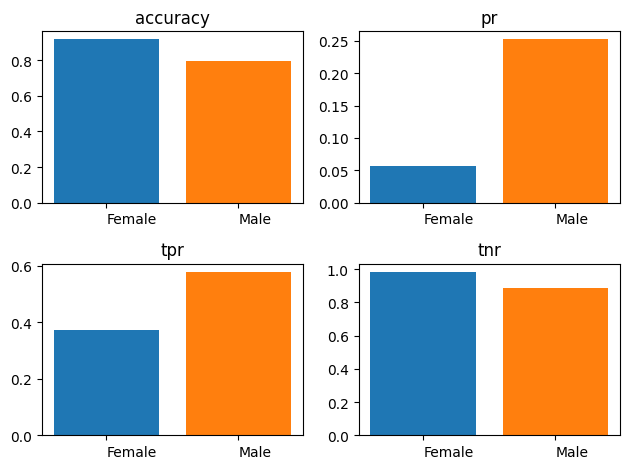

accuracy,0.916
pr,0.057
tpr,0.373
tnr,0.982
accuracy,0.795
pr,0.252
tpr,0.578
tnr,0.888


In [8]:
report = fb.report(predictions=yhat, labels=y, sensitive=sensitive, metrics=[fb.accuracy, fb.pr, fb.tpr, fb.tnr])
fb.visualize(report)
report

## Specialized reports
The preferred type of reporting for complex fairness assessment settings should be by specialized reports that produce the same numerical assessment values each time. Here we will look at `fb.multireport`, which makes pairwise comparisons between all sensitive attribute branches (i.e., columns) and runs reduction operations to summarize the result. More report types are available that yield the exact same entries, regardless of the number of sensitive attributes or whether you apply intersectional analysis to create combinations. In other words, even hundreds of sensitive attributes and combinations are summarized in the same report.

Even specialized reports are forks; each column is a branch corresponding to one type of summary across all population groups. In the report below, the computed types of summary are the minimum of assessment values (min), their average weighted by group size (wmean), the gini deviation between them (0 indicates non-bias), the minimum ratio of assessments (minratio), and the maximum difference of assessments (maxdiff). The last three columns contain reductions that hold meaning only for scoring, recommendation, or regressions tasks and are not computed in our classification schenario.

In [9]:
report = fb.multireport(predictions=yhat, labels=y, sensitive=sensitive)
report

accuracy,0.795
pr,0.057
tpr,0.373
tnr,0.888
accuracy,0.835
pr,0.187
tpr,0.510
tnr,0.919
accuracy,0.035
pr,0.316
tpr,0.108


You can look at the values of specialized reports to get a rough picture of how well the model behaves in terms of fairness. FairBench lets you explore problematic values by backtracking computations too. The exploration can be either programmatic, as if you 

In [10]:
import IPython
html_page = fb.interactive_html(report, show=False)
IPython.display.HTML(html_page)

## Explain values
All reports can be computed on specific measures.

Can unpack reports by accessing rows or columns as members.

In [11]:
report.accuracy ## this is also a Fork, since it would obtain a unique value for each branch

min,0.795
wmean,0.835
gini,0.035
minratio,0.868
maxdiff,0.121
maxbarea,---
maxrarea,---
maxbdcg,---


In [12]:
report.min  ## this is a dictionary of assessments

{'accuracy': np.float64(0.7950276243093923),
 'pr': np.float64(0.056631617782696916),
 'tpr': np.float64(0.3728813559322034),
 'tnr': np.float64(0.8878221988427144)}

You can also erase entries from each branch thank to transparent wrapping of of branch data objects, i.e., the same mechanism that let us compute sensitive.sum() for each branch.

In [13]:
del report["accuracy"]
report

pr,0.057
tpr,0.373
tnr,0.888
pr,0.187
tpr,0.510
tnr,0.919
pr,0.316
tpr,0.108
tnr,0.025
pr,0.225
tpr,0.645


Custom reductions can be created with the corresponding interface. These will be reports.

Report values are of type Explainable. This has a value and an explain field. 

In [14]:
print(report.minratio.pr)
type(report.minratio.pr)

0.225


fairbench.core.explanation.base.Explainable

In [15]:
print(report.minratio.pr.value)
print(report.minratio.pr.explain)

0.22478778111114348
Female: 0.057
Male: 0.252


The explain field is a Fork that keeps track of individual evaluations that have contributed to the result. This way, we can backtrack explanations and find which groups are more disadvantaged after finding measures on which imbalances exist.

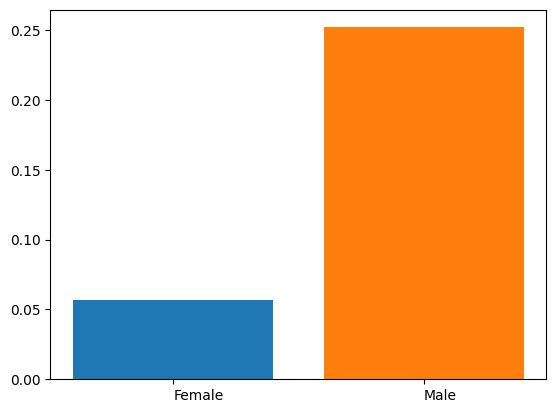

In [16]:
fb.visualize(report.minratio.pr.explain)

The worst accuracy is for Male&Asian-Pac-Islander, which means that any bias mitigation should start from exploring issues that arise for this subgroup.